# OLS Regression Model

In [7]:
import pandas as pd
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder

In [8]:
data = pd.read_csv('lsoa_with_crime_hmo_counts.csv')

In [9]:
# Remove columns that contain 'Does not apply'
filtered_data = data.drop(columns=[col for col in data.columns if 'Does not apply' in col])

In [10]:
# Exclude economically active variables related to employment
variables_to_exclude = [col for col in filtered_data.columns if 'Economically active' in col]

# Correcting the missing parenthesis here
remaining_features = filtered_data.columns.drop(['total_crime'] + variables_to_exclude)

# Remove columns that contain 'Does not apply'
filtered_data = data.drop(columns=[col for col in data.columns if 'Does not apply' in col])

# Exclude columns that contain 'Economically active'
filtered_data = filtered_data.drop(columns=[col for col in filtered_data.columns if 'Economically active' in col])

# Prepare the data again for regression analysis
all_features_filtered = filtered_data.columns.drop(['total_crime'])
target_variable = 'total_crime'

X_filtered = filtered_data[all_features_filtered]
y_filtered = filtered_data[target_variable]

# Add a constant term for the intercept
X_filtered = sm.add_constant(X_filtered)

# Encode non-numeric columns
label_encoders = {}
for column in X_filtered.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_filtered[column] = le.fit_transform(X_filtered[column])
    label_encoders[column] = le

# Check for multicollinearity using VIF
vif_data_filtered = pd.DataFrame()
vif_data_filtered["feature"] = X_filtered.columns
vif_data_filtered["VIF"] = [variance_inflation_factor(X_filtered.values, i) for i in range(X_filtered.shape[1])]

# Remove features with high VIF (threshold: 10)
high_vif_columns_filtered = vif_data_filtered[vif_data_filtered["VIF"] > 10]["feature"].tolist()
X_filtered_reduced = X_filtered.drop(columns=high_vif_columns_filtered)

# Fit the regression model again with reduced features
model_filtered_reduced = sm.OLS(y_filtered, X_filtered_reduced).fit()

# Extract the coefficients from the regression model
coefficients_filtered = model_filtered_reduced.params

# Sort the coefficients to find the top 10 positive and negative impacts
sorted_coefficients_filtered = coefficients_filtered.sort_values()

# Top 10 negative impacts
top_10_negative_impacts_filtered = sorted_coefficients_filtered.head(10)

# Top 10 positive impacts
top_10_positive_impacts_filtered = sorted_coefficients_filtered.tail(10)

# Print the summary of the regression results
print(model_filtered_reduced.summary())

# Extract and display the top 10 positive and negative impacts in DataFrames
top_10_negative_df = pd.DataFrame({
    'Feature': top_10_negative_impacts_filtered.index,
    'Coefficient': top_10_negative_impacts_filtered.values,
    'P-value': model_filtered_reduced.pvalues[top_10_negative_impacts_filtered.index]
})

top_10_positive_df = pd.DataFrame({
    'Feature': top_10_positive_impacts_filtered.index,
    'Coefficient': top_10_positive_impacts_filtered.values,
    'P-value': model_filtered_reduced.pvalues[top_10_positive_impacts_filtered.index]
})

print(top_10_negative_df)
print(top_10_positive_df)

C:\Users\samue\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                 OLS Regression Results                                
Dep. Variable:            total_crime   R-squared (uncentered):                   0.741
Model:                            OLS   Adj. R-squared (uncentered):              0.719
Method:                 Least Squares   F-statistic:                              34.10
Date:                Wed, 14 Aug 2024   Prob (F-statistic):                    3.82e-50
Time:                        14:50:23   Log-Likelihood:                         -784.53
No. Observations:                 220   AIC:                                      1603.
Df Residuals:                     203   BIC:                                      1661.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                                                                                                                        

# Random Forest Regression Model

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

                           Metric       Value
0        Mean Squared Error (MSE)  124.344211
1  Root Mean Squared Error (RMSE)   11.150974
2       Mean Absolute Error (MAE)    8.050682
3                  R-squared (R²)    0.248056
4            Accuracy within ±10%   15.909091


C:\Users\samue\AppData\Local\Temp\ipykernel_3184\1702280638.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


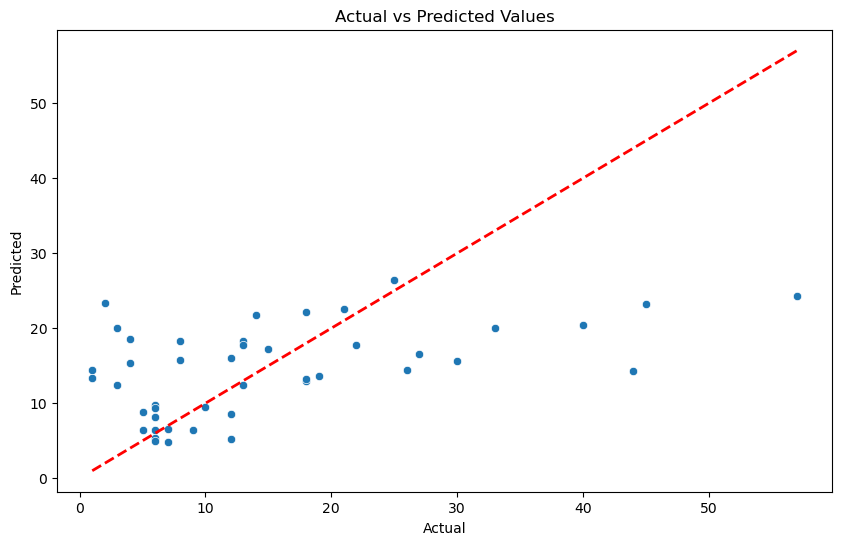

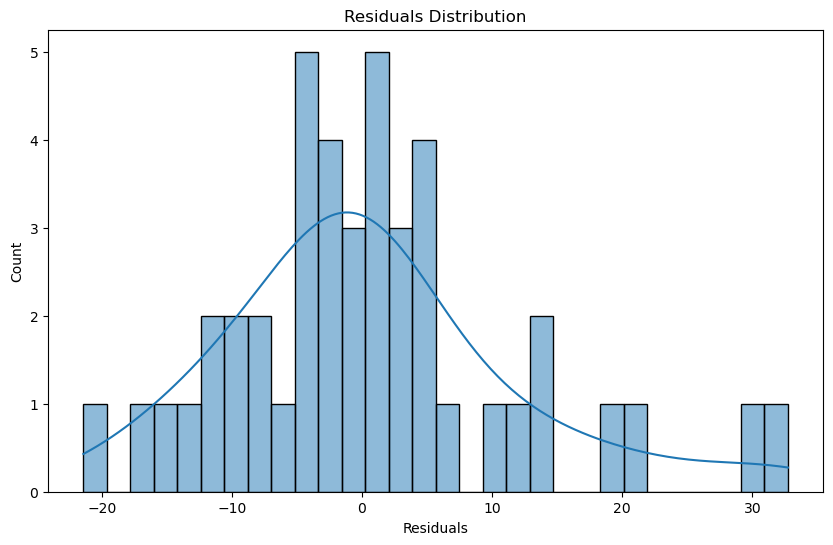

In [15]:
# Load the dataset
file_path = 'lsoa_with_crime_hmo_counts.csv'
data = pd.read_csv(file_path)

# Drop identifier columns
data = data.drop(columns=['FeatureID', 'LSOA21CD', 'LSOA21NM'])

# Separate features and target variable
X = data.drop(columns=['total_crime'])
y = data['total_crime']

# Identify non-numeric columns
non_numeric_columns = X.select_dtypes(include=['object']).columns

# Drop non-numeric columns
X = X.drop(columns=non_numeric_columns)

# Handle missing values by filling with median value (if any)
X = X.fillna(X.median())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate the percentage error for each prediction
percentage_errors = abs((y_test - y_pred) / y_test) * 100

# Determine the predictions within ±10% of the actual values
within_10_percent = percentage_errors <= 10

# Calculate the accuracy
accuracy_within_10_percent = within_10_percent.mean() * 100

# Display evaluation metrics neatly
evaluation_df = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'R-squared (R²)', 'Accuracy within ±10%'],
    'Value': [mse, rmse, mae, r2, accuracy_within_10_percent]
})
print(evaluation_df)

# Plot true vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Residuals Distribution')
plt.show()


# Improved Random Forest

                                              Feature  Importance
2              Household is deprived in one dimension    0.169613
16  Economically active and a full-time student: I...    0.064470
15  Economically active and a full-time student: I...    0.045504
51                                       White: Irish    0.042061
31  Level 4 qualifications or above: degree (BA, B...    0.040350


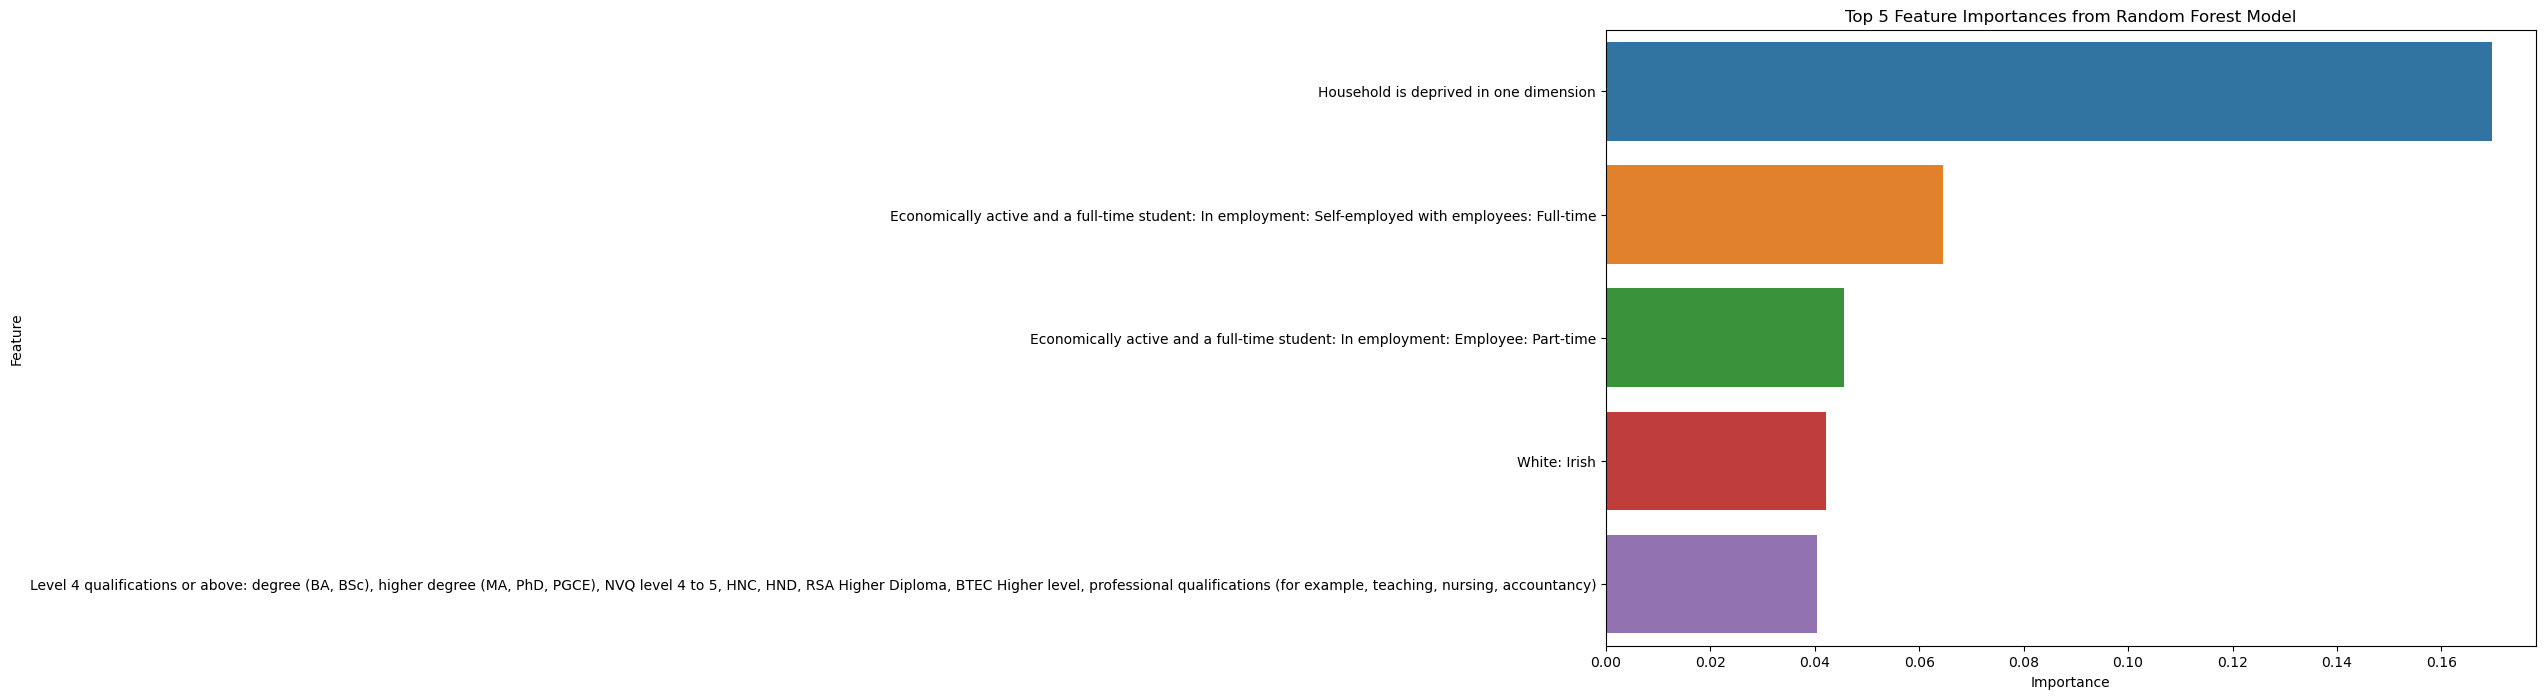

Fitting 3 folds for each of 243 candidates, totalling 729 fits
                           Metric       Value
0        Mean Squared Error (MSE)  133.884402
1  Root Mean Squared Error (RMSE)   11.570843
2       Mean Absolute Error (MAE)    7.976789
3                  R-squared (R²)    0.190364
4            Accuracy within ±10%   13.636364


C:\Users\samue\AppData\Local\Temp\ipykernel_3184\3934166513.py:107: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


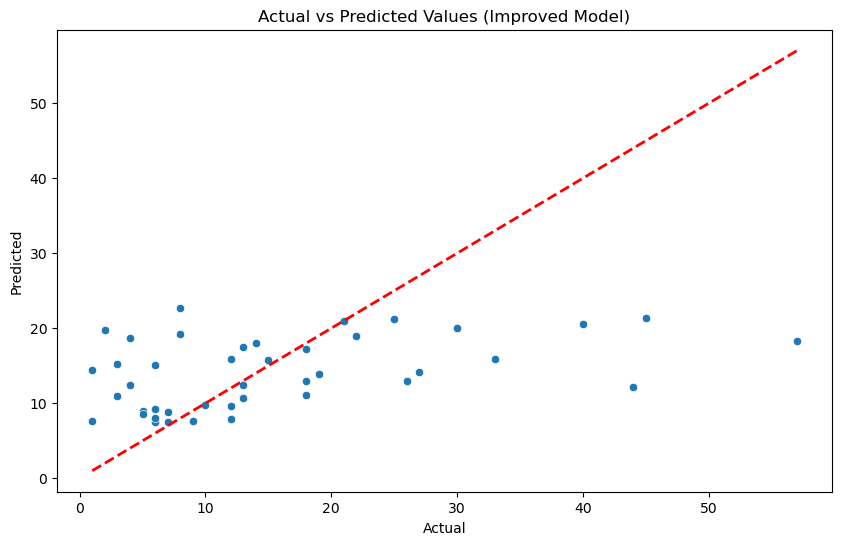

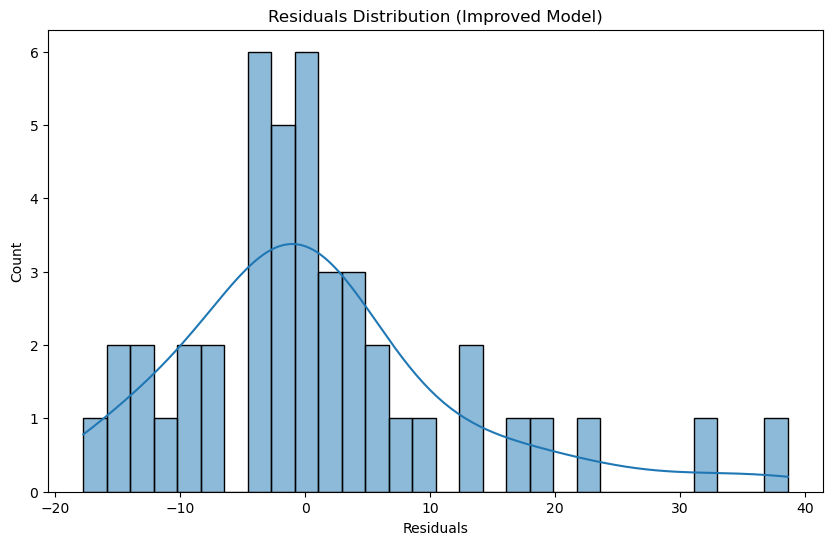

,Metric,Value
0,Mean Squared Error (MSE),133.884402
1,Root Mean Squared Error (RMSE),11.570843
2,Mean Absolute Error (MAE),7.976789
3,R-squared (R²),0.190364
4,Accuracy within ±10%,13.636364


In [17]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'lsoa_with_crime_hmo_counts.csv'
data = pd.read_csv(file_path)

# Drop identifier columns
data = data.drop(columns=['FeatureID', 'LSOA21CD', 'LSOA21NM'])

# Separate features and target variable
X = data.drop(columns=['total_crime'])
y = data['total_crime']

# Identify non-numeric columns
non_numeric_columns = X.select_dtypes(include=['object']).columns

# Drop non-numeric columns
X = X.drop(columns=non_numeric_columns)

# Handle missing values by filling with median value (if any)
X = X.fillna(X.median())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model to get feature importances
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the DataFrame by importance and get the top 5
top_5_features = feature_importances_df.sort_values(by='Importance', ascending=False).head(5)

# Display the top 5 features
print(top_5_features)

# Plot the top 5 feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_5_features)
plt.title('Top 5 Feature Importances from Random Forest Model')
plt.show()

# Feature Selection using Random Forest
selector = SelectFromModel(rf_model)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Hyperparameter Tuning with Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_selected, y_train)

# Get the best parameters and train the model
best_gbr = grid_search.best_estimator_
y_pred_best = best_gbr.predict(X_test_selected)

# Evaluate the improved model
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = mse_best ** 0.5
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Calculate the percentage error for each prediction
percentage_errors_best = abs((y_test - y_pred_best) / y_test) * 100

# Determine the predictions within ±10% of the actual values
within_10_percent_best = percentage_errors_best <= 10

# Calculate the accuracy
accuracy_within_10_percent_best = within_10_percent_best.mean() * 100

# Display evaluation metrics neatly
evaluation_df_improved = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'R-squared (R²)', 'Accuracy within ±10%'],
    'Value': [mse_best, rmse_best, mae_best, r2_best, accuracy_within_10_percent_best]
})
print(evaluation_df_improved)

# Plot true vs predicted values for improved model
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Improved Model)')
plt.show()

# Plot residuals for improved model
residuals_best = y_test - y_pred_best
plt.figure(figsize=(10, 6))
sns.histplot(residuals_best, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Residuals Distribution (Improved Model)')
plt.show()

evaluation_df_improved
